In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
import optuna
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, mutual_info_classif, mutual_info_regression
from sklearn.pipeline import Pipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from keras_tuner.tuners import RandomSearch
from tensorflow import keras
import kerastuner as kt
from tensorflow.keras.callbacks import ModelCheckpoint
from funcs_7_lab import *
import os
import logging
from tensorflow import keras
import warnings

c:\Users\My Computer\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\My Computer\AppData\Local\Temp\ipykernel_9076\3342646072.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
warnings.filterwarnings('ignore')

In [3]:
N_SAMPLES = 60000

In [4]:
class_df = pd.read_csv('../data/csgo_processed.csv', sep=';')
class_y = class_df['bomb_planted'].values[:N_SAMPLES]
class_X = class_df.drop(['bomb_planted'], axis=1).values[:N_SAMPLES]
oversampler = SMOTE(random_state=0)
class_X, class_y = oversampler.fit_resample(class_X, class_y)
class_ss = StandardScaler()
class_X = class_ss.fit_transform(class_X)

In [5]:
reg_df = pd.read_csv('../data/diamonds_processed.csv', sep=';')
reg_y = reg_df['price'].values[:N_SAMPLES]
reg_X = reg_df.drop(['price'], axis=1).values[:N_SAMPLES]
reg_ss = StandardScaler()
reg_X = reg_ss.fit_transform(reg_X)

In [6]:
k_best_cls = SelectKBest(score_func=f_classif, k=2)
k_best_reg = SelectKBest(score_func=f_regression, k=9)
class_X = k_best_cls.fit_transform(class_X, class_y)
reg_X = k_best_reg.fit_transform(reg_X, reg_y)

In [7]:
categorical_y = tf.keras.utils.to_categorical(class_y)

In [8]:
class_X_train, class_X_test, class_y_train, class_y_test = train_test_split(class_X, categorical_y, test_size=0.2, random_state=0)
reg_X_train, reg_X_test, reg_y_train, reg_y_test = train_test_split(reg_X, reg_y, test_size=0.2, random_state=0)

In [9]:
mlp_rand_param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100, 200, 500, 1000]
}

space = {
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 100)]),
    'activation': hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
    'solver': hp.choice('solver', ['lbfgs', 'sgd', 'adam']),
    'alpha': hp.loguniform('alpha', -4, -2),
    'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
    'max_iter': hp.choice('max_iter', [200, 500, 1000]),
    'early_stopping': hp.choice('early_stopping', [True, False]),
    'n_iter_no_change': 10
}

In [10]:
class_mlp = MLPClassifier()

kf = KFold(n_splits=10)

random_search = RandomizedSearchCV(class_mlp, param_distributions=mlp_rand_param_dist, n_iter=10, cv=kf, n_jobs=-1)

random_search.fit(class_X_train, class_y_train)
print("MLPClassifier:")
print("Best score found: ", random_search.best_score_)
print("Best parameters found: ", random_search.best_params_)

best_params = random_search.best_params_.copy()

if 'hidden_layer_sizes' in best_params and isinstance(best_params['hidden_layer_sizes'], str):
    best_params['hidden_layer_sizes'] = ast.literal_eval(best_params['hidden_layer_sizes'])

class_random_mlp = MLPClassifier(**best_params)
class_random_mlp.fit(class_X_train, class_y_train)

MLPClassifier:
Best score found:  0.9124118020191638
Best parameters found:  {'solver': 'lbfgs', 'max_iter': 1000, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'relu'}


MLPClassifier(alpha=0.01, learning_rate='invscaling', max_iter=1000,
              solver='lbfgs')

In [11]:
reg_mlp = MLPRegressor()

kf = KFold(n_splits=10)

random_search = RandomizedSearchCV(reg_mlp, param_distributions=mlp_rand_param_dist, n_iter=10, cv=kf, n_jobs=-1)

random_search.fit(reg_X_train, reg_y_train)
print("MLPRegressor:")
print("Best score found: ", random_search.best_score_)
print("Best parameters found: ", random_search.best_params_)

best_params = random_search.best_params_.copy()

if 'hidden_layer_sizes' in best_params and isinstance(best_params['hidden_layer_sizes'], str):
    best_params['hidden_layer_sizes'] = ast.literal_eval(best_params['hidden_layer_sizes'])

reg_random_mlp = MLPRegressor(**best_params)
reg_random_mlp.fit(reg_X_train, reg_y_train)

MLPRegressor:
Best score found:  0.9785114331399708
Best parameters found:  {'solver': 'lbfgs', 'max_iter': 1000, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.1, 'activation': 'relu'}


MLPRegressor(alpha=0.1, max_iter=1000, solver='lbfgs')

In [13]:
def objective(trial):
    params = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 100)]),
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
        'alpha': trial.suggest_categorical('alpha', [0.0001, 0.001, 0.01, 0.1]),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        'max_iter': trial.suggest_categorical('max_iter', [100, 200, 500, 1000])
    }
    
    mlp = MLPClassifier(**params)
    score = cross_val_score(mlp, class_X_train, class_y_train, cv=10, n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print("Optuna:")
print("Best score found: ", study.best_value)
print("Best parameters found: ", study.best_params)
class_optuna_mlp = MLPClassifier(**study.best_params)
class_optuna_mlp.fit(class_X_train, class_y_train)

[I 2025-06-01 19:57:04,323] A new study created in memory with name: no-name-c69b2efc-8a6e-4ad9-b8a4-f043f4bef406
[I 2025-06-01 19:57:10,058] Trial 0 finished with value: 0.8825907925707408 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'identity', 'solver': 'sgd', 'alpha': 0.001, 'learning_rate': 'constant', 'max_iter': 100}. Best is trial 0 with value: 0.8825907925707408.
[I 2025-06-01 20:02:08,507] Trial 1 finished with value: 0.9117161057013122 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.1, 'learning_rate': 'adaptive', 'max_iter': 500}. Best is trial 1 with value: 0.9117161057013122.
[I 2025-06-01 20:03:51,769] Trial 2 finished with value: 0.9093459728516351 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'max_iter': 500}. Best is trial 1 with value: 0.9117161057013122.
[I 2025-06-01 20:04:39,720] Trial 3 finished with val

Optuna:
Best score found:  0.9130131503716408
Best parameters found:  {'hidden_layer_sizes': (100, 100), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'max_iter': 1000}


MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='adaptive',
              max_iter=1000, solver='lbfgs')

In [ ]:
# def objective(trial):
#     params = {
#         'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 100)]),
#         'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
#         'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
#         'alpha': trial.suggest_categorical('alpha', [0.0001, 0.001, 0.01, 0.1]),
#         'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
#         'max_iter': trial.suggest_categorical('max_iter', [200, 500, 1000]),
#         'early_stopping': trial.suggest_categorical('early_stopping', [True, False]),
#         'n_iter_no_change': 10
#     }
    
#     mlp = MLPRegressor(**params)
#     score = cross_val_score(mlp, reg_X_train, reg_y_train, cv=10, n_jobs=-1).mean()
#     return score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print("Optuna:")
# print("Best score found: ", study.best_value)
# print("Best parameters found: ", study.best_params)
# # reg_mlp = MLPRegressor(**study.best_params)
# # reg_mlp.fit(reg_X_train, reg_y_train)

In [15]:
from hyperopt import fmin, tpe, Trials, space_eval
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK


def objective(params):
    mlp = MLPClassifier(**params)
    score = cross_val_score(mlp, class_X_train, class_y_train, cv=10, n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

best_params_parsed = space_eval(space, best_params)

print("Hyperopt:")
print("Best score found: ", -trials.best_trial['result']['loss'])
print("Best parameters found: ", best_params_parsed)

class_hyperopt_mlp = MLPClassifier(**best_params_parsed)
class_hyperopt_mlp.fit(class_X_train, class_y_train)

100%|██████████| 10/10 [23:54<00:00, 143.44s/trial, best loss: -0.912541492581642]
Hyperopt:
Best score found:  0.912541492581642
Best parameters found:  {'activation': 'logistic', 'alpha': 0.01851159680517323, 'early_stopping': False, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 1000, 'n_iter_no_change': 10, 'solver': 'lbfgs'}


MLPClassifier(activation='logistic', alpha=0.01851159680517323,
              learning_rate='adaptive', max_iter=1000, solver='lbfgs')

In [ ]:
# def objective(params):
#     mlp = MLPRegressor(**params)
#     score = cross_val_score(mlp, reg_X_train, reg_y_train, cv=10, n_jobs=-1).mean()
#     return {'loss': -score, 'status': STATUS_OK}

# trials = Trials()

# best_params = fmin(objective, reg_space, algo=tpe.suggest, max_evals=100, trials=trials)
# print("Hyperopt:")
# print("Best score found: ", -trials.best_trial['result']['loss'])
# print("Best parameters found: ", best_params)
# # reg_mlp = MLPRegressor(**best_params)

In [16]:
def objective(trial):
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(class_X_train.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
    
    optimizers = {
        'adam': keras.optimizers.Adam(learning_rate=lr),
        'sgd': keras.optimizers.SGD(learning_rate=lr),
        'rmsprop': keras.optimizers.RMSprop(learning_rate=lr)
    }
    
    model.compile(
        optimizer=optimizers[optimizer_name],
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    val_accuracies = []
    
    for train_idx, val_idx in kfold.split(class_X_train):
        X_train_fold, X_val_fold = class_X_train[train_idx], class_X_train[val_idx]
        y_train_fold, y_val_fold = class_y_train[train_idx], class_y_train[val_idx]
        
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=10,
            verbose=0
        )
        val_accuracies.append(history.history['val_accuracy'][-1])
        
        model.set_weights(model.get_weights())
        
    return np.mean(val_accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
class_optuna_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(class_X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

optimizers = {
    'adam': keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    'sgd': keras.optimizers.SGD(learning_rate=best_params['learning_rate']),
    'rmsprop': keras.optimizers.RMSprop(learning_rate=best_params['learning_rate'])
}

class_optuna_model.compile(
    optimizer=optimizers[best_params['optimizer']],
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

class_optuna_nn_history = class_optuna_model.fit(
    class_X_train, class_y_train,
    epochs=10,
    verbose=0
)

loss, accuracy = class_optuna_model.evaluate(class_X_test, class_y_test)
print(f"Лучшие гиперпараметры: {best_params}")
print(f"Тестовая точность: {accuracy:.4f}")
class_optuna_nn = class_optuna_model

[I 2025-06-01 22:01:00,800] A new study created in memory with name: no-name-079a1458-82f9-4d2b-b10f-b38aa59e4066
[I 2025-06-01 22:04:08,000] Trial 0 finished with value: 0.9078722298145294 and parameters: {'optimizer': 'adam', 'learning_rate': 0.00026238576787802556}. Best is trial 0 with value: 0.9078722298145294.
[I 2025-06-01 22:07:18,366] Trial 1 finished with value: 0.90439373254776 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.0002261831054243738}. Best is trial 0 with value: 0.9078722298145294.
[I 2025-06-01 22:10:21,156] Trial 2 finished with value: 0.9064570069313049 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.004985762637682528}. Best is trial 0 with value: 0.9078722298145294.
[I 2025-06-01 22:13:23,722] Trial 3 finished with value: 0.9072233319282532 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.0014641779257200014}. Best is trial 0 with value: 0.9078722298145294.
[I 2025-06-01 22:16:27,834] Trial 4 finished with value: 0.90530154

663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.8944 - loss: 0.2577
Лучшие гиперпараметры: {'optimizer': 'adam', 'learning_rate': 0.00976330825381888}
Тестовая точность: 0.8953


In [17]:
def build_class_model(hp):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(class_X_train.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
    
    optimizer_name = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    optimizers = {
        'adam': keras.optimizers.Adam(learning_rate=lr),
        'sgd': keras.optimizers.SGD(learning_rate=lr),
        'rmsprop': keras.optimizers.RMSprop(learning_rate=lr)
    }
    
    model.compile(
        optimizer=optimizers[optimizer_name],
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_class_model,
    objective='val_accuracy',
    max_trials=10,
    directory='keras_tuner',
    project_name='class_model'
)

tuner.search(
    class_X_train, class_y_train,
    epochs=10,
    validation_data=(class_X_test, class_y_test),
    verbose=1
)

class_kt_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(f"Лучшие гиперпараметры:")
print(f"Оптимизатор: {best_hps.get('optimizer')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

loss, accuracy = class_kt_model.evaluate(class_X_test, class_y_test)
print(f"\nТестовая точность: {accuracy:.4f}")

Trial 9 Complete [00h 00m 25s]
val_accuracy: 0.9025563597679138

Best val_accuracy So Far: 0.9080275297164917
Total elapsed time: 00h 03m 43s
Лучшие гиперпараметры:
Оптимизатор: adam
Learning Rate: 0.001
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.9051 - loss: 0.2495

Тестовая точность: 0.9080


In [18]:
best_hps = tuner.get_best_hyperparameters()[0]
optimizer_name = best_hps.get('optimizer')
learning_rate = best_hps.get('learning_rate')

class_kt_nn = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(class_X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

optimizers = {
    'adam': keras.optimizers.Adam(learning_rate=learning_rate),
    'sgd': keras.optimizers.SGD(learning_rate=learning_rate),
    'rmsprop': keras.optimizers.RMSprop(learning_rate=learning_rate)
}
optimizer = optimizers[optimizer_name]

class_kt_nn.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

class_kt_nn_history = class_kt_nn.fit(
    class_X_train, class_y_train,
    epochs=10,
    verbose=0
)

In [19]:
def objective(trial):
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(reg_X_train.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    
    optimizers = {
        'adam': keras.optimizers.Adam(learning_rate=lr),
        'sgd': keras.optimizers.SGD(learning_rate=lr),
        'rmsprop': keras.optimizers.RMSprop(learning_rate=lr)
    }
    
    model.compile(
        optimizer=optimizers[optimizer_name],
        loss='mse',
        metrics=['mae']
    )
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    val_losses = []
    
    for train_idx, val_idx in kfold.split(reg_X_train):
        X_train_fold, X_val_fold = reg_X_train[train_idx], reg_X_train[val_idx]
        y_train_fold, y_val_fold = reg_y_train[train_idx], reg_y_train[val_idx]
        
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=10,
            verbose=0
        )
        val_losses.append(history.history['val_loss'][-1])
        
    return np.mean(val_losses)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
reg_optuna_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(reg_X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

optimizers = {
    'adam': keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    'sgd': keras.optimizers.SGD(learning_rate=best_params['learning_rate']),
    'rmsprop': keras.optimizers.RMSprop(learning_rate=best_params['learning_rate'])
}

reg_optuna_model.compile(
    optimizer=optimizers[best_params['optimizer']],
    loss='mse',
    metrics=['mae']
)

reg_optuna_nn_history = reg_optuna_model.fit(
    reg_X_train, reg_y_train,
    epochs=10,
    verbose=0
)

loss, mae = reg_optuna_model.evaluate(reg_X_test, reg_y_test)
print(f"Лучшие гиперпараметры: {best_params}")
print(f"Тестовая MSE: {loss:.4f}, MAE: {mae:.4f}")
reg_optuna_nn = reg_optuna_model

[I 2025-06-01 22:45:01,797] A new study created in memory with name: no-name-89aadafb-c5d7-46fe-a575-e3b803b347f1
[I 2025-06-01 22:46:31,626] Trial 0 finished with value: 1135789.6875 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.0008514459846003332}. Best is trial 0 with value: 1135789.6875.
[I 2025-06-01 22:47:59,967] Trial 1 finished with value: 1649224.775 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.0001226154131731761}. Best is trial 0 with value: 1135789.6875.
[I 2025-06-01 22:49:33,106] Trial 2 finished with value: 651335.59375 and parameters: {'optimizer': 'adam', 'learning_rate': 0.004697299355243904}. Best is trial 2 with value: 651335.59375.
[I 2025-06-01 22:51:04,071] Trial 3 finished with value: 1592043.1375 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.00017853345138360124}. Best is trial 2 with value: 651335.59375.
[I 2025-06-01 22:52:37,218] Trial 4 finished with value: 850704.43125 and parameters: {'optimizer': 'rmsprop', 'le

333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 1083192.6250 - mae: 533.7586
Лучшие гиперпараметры: {'optimizer': 'adam', 'learning_rate': 0.004697299355243904}
Тестовая MSE: 1095742.5000, MAE: 536.5680


In [20]:
def build_reg_model(hp):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(reg_X_train.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    
    optimizer_name = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    optimizers = {
        'adam': keras.optimizers.Adam(learning_rate=lr),
        'sgd': keras.optimizers.SGD(learning_rate=lr),
        'rmsprop': keras.optimizers.RMSprop(learning_rate=lr)
    }
    
    model.compile(
        optimizer=optimizers[optimizer_name],
        loss='mse',
        metrics=['mae']
    )
    return model

tuner = kt.RandomSearch(
    build_reg_model,
    objective='val_loss',
    max_trials=10,
    directory='keras_tuner',
    project_name='reg_model'
)

tuner.search(
    reg_X_train, reg_y_train,
    epochs=10,
    validation_data=(reg_X_test, reg_y_test),
    verbose=1
)

reg_kt_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(f"Лучшие гиперпараметры:")
print(f"Оптимизатор: {best_hps.get('optimizer')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

test_loss, test_mae = reg_kt_model.evaluate(reg_X_test, reg_y_test)
print(f"\nТестовая MSE: {test_loss:.4f}, MAE: {test_mae:.4f}")

Trial 9 Complete [00h 00m 12s]
val_loss: nan

Best val_loss So Far: 958604.5625
Total elapsed time: 00h 01m 54s
Лучшие гиперпараметры:
Оптимизатор: rmsprop
Learning Rate: 0.01
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 942380.8750 - mae: 491.8069

Тестовая MSE: 958604.5625, MAE: 494.8827


In [21]:
best_hps = tuner.get_best_hyperparameters()[0]
optimizer_name = best_hps.get('optimizer')
learning_rate = best_hps.get('learning_rate')

new_reg_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(reg_X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

optimizers = {
    'adam': keras.optimizers.Adam(learning_rate=learning_rate),
    'sgd': keras.optimizers.SGD(learning_rate=learning_rate),
    'rmsprop': keras.optimizers.RMSprop(learning_rate=learning_rate)
}

optimizer = optimizers[optimizer_name]

new_reg_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

reg_kt_nn_history = new_reg_model.fit(
    reg_X_train, reg_y_train,
    epochs=10,
    verbose=0
)

reg_kt_nn = new_reg_model

In [22]:
class_metrics = ["Recall", "Accuracy", "Precision", "Epochs", "Optimizer"]
class_model_names = ['optuna_mlp', 'random_mlp', 'hyperopt_mlp', 'optuna_nn', 'kt_nn']
class_models = [class_optuna_mlp, class_random_mlp, class_hyperopt_mlp, class_optuna_nn, class_kt_nn]

df_classification = evaluate_models(
    class_models, 
    class_model_names,
    class_X_train, class_y_train,
    class_X_test, class_y_test,
    class_metrics,
    'classification'
)

reg_metrics = ["R2", "MSE", "MAE", "Epochs", "Optimizer"]
reg_model_names = ['random_mlp', 'optuna_nn', 'kt_nn']
reg_models = [reg_random_mlp, reg_optuna_nn, reg_kt_nn]

df_regression = evaluate_models(
    reg_models,
    reg_model_names,
    reg_X_train, reg_y_train,
    reg_X_test, reg_y_test,
    reg_metrics,
    'regression'
)

print("Классификация:")
print(df_classification)
print("\nРегрессия:")
print(df_regression)

2651/2651 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step
663/663 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step
663/663 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step
Классификация:
              Train                                       Test           \
             Recall Accuracy Precision Epochs Optimizer Recall Accuracy   
optuna_mlp     0.91     0.91      0.91     10    L-BFGS   0.91     0.91   
random_mlp     0.91     0.91      0.91     10    L-BFGS   0.91     0.91   
hyperopt_mlp   0.91     0.91      0.91     10    L-BFGS   0.91     0.91   
optuna_nn      0.90     0.90      0.90     10      adam   0.90     0.90   
kt_nn          0.90     0.90      0.91     10      adam   0.90     0.90   

                                         
             Precision Epochs Optimizer  
optuna_mlp        0.91 

In [23]:
class_mlp = class_optuna_mlp
reg_mlp = reg_random_mlp
class_nn = class_kt_nn
reg_nn = reg_kt_nn

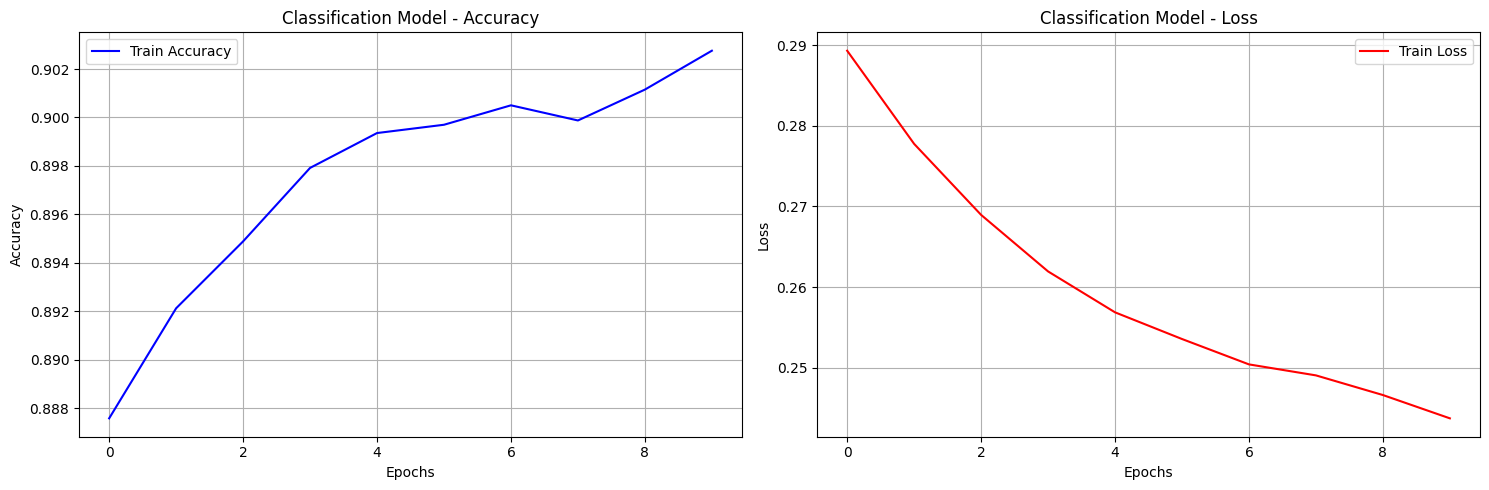

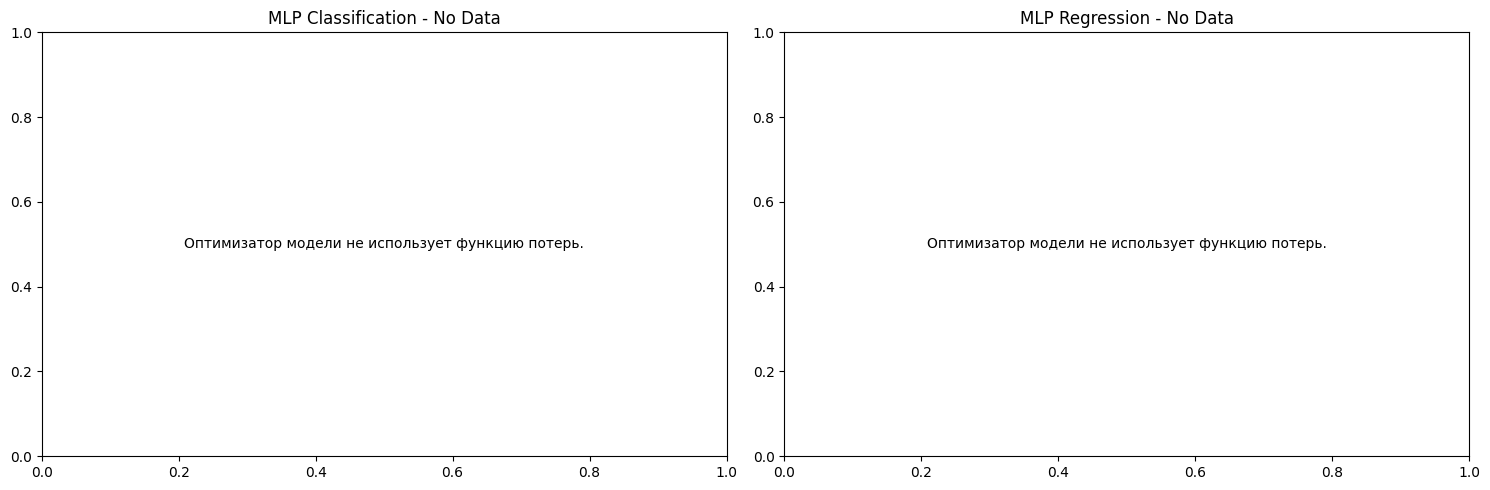

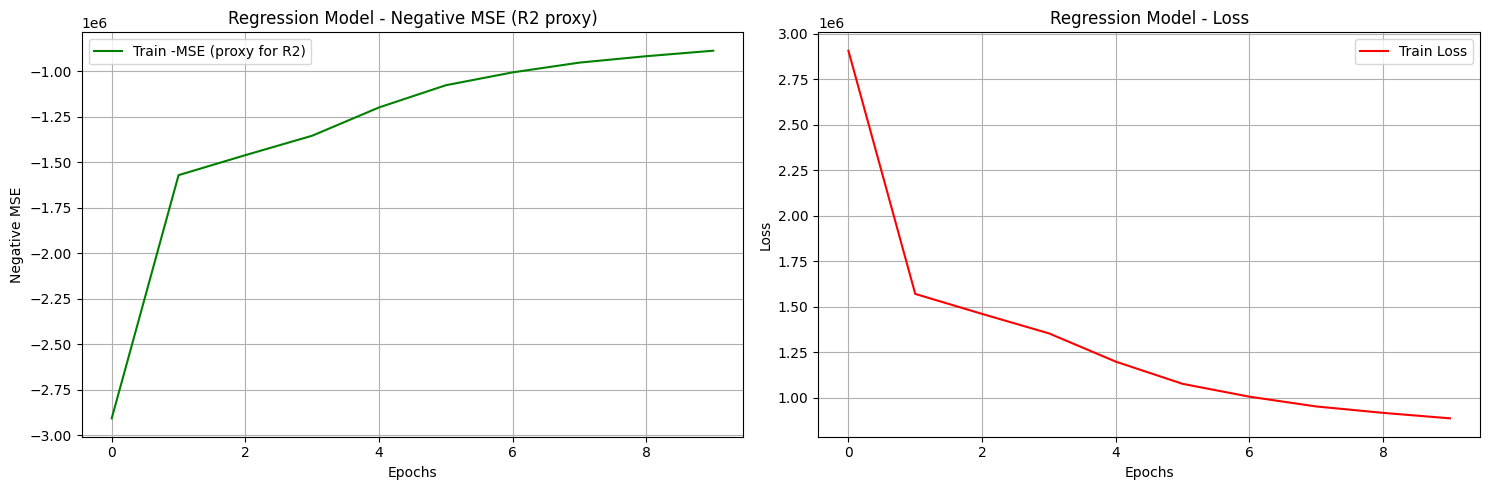

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(class_kt_nn_history.history['accuracy'], label='Train Accuracy', color='blue')
if 'val_accuracy' in class_kt_nn_history.history:
    axes[0].plot(class_kt_nn_history.history['val_accuracy'], label='Val Accuracy', color='lightblue')
axes[0].set_title('Classification Model - Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(class_kt_nn_history.history['loss'], label='Train Loss', color='red')
if 'val_loss' in class_kt_nn_history.history:
    axes[1].plot(class_kt_nn_history.history['val_loss'], label='Val Loss', color='lightcoral')
axes[1].set_title('Classification Model - Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

try:
    axes[0].plot(class_optuna_mlp.loss_curve_, label='Train Loss', color='purple') # указывать оригинальные переменные моделей
    axes[0].set_title('MLP Classification - Loss Curve')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
except:
    axes[0].text(0.5, 0.5, 'Оптимизатор модели не использует функцию потерь.', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('MLP Classification - No Data')

try:
    axes[1].plot(reg_random_mlp.loss_curve_, label='Train Loss', color='orange') # указывать оригинальные переменные моделей
    axes[1].set_title('MLP Regression - Loss Curve')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
except:
    axes[1].text(0.5, 0.5, 'Оптимизатор модели не использует функцию потерь.', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('MLP Regression - No Data')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

if 'r2_score' in reg_kt_nn_history.history:
    axes[0].plot(reg_kt_nn_history.history['r2_score'], label='Train R2', color='green')
    if 'val_r2_score' in reg_kt_nn_history.history:
        axes[0].plot(reg_kt_nn_history.history['val_r2_score'], label='Val R2', color='lightgreen')
    axes[0].set_title('Regression Model - R2 Score')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('R2 Score')
    axes[0].legend()
    axes[0].grid(True)
else:
    mse_values = reg_kt_nn_history.history['mean_squared_error'] if 'mean_squared_error' in reg_kt_nn_history.history else reg_kt_nn_history.history['loss']
    axes[0].plot([-x for x in mse_values], label='Train -MSE (proxy for R2)', color='green')
    if 'val_mean_squared_error' in reg_kt_nn_history.history:
        val_mse = reg_kt_nn_history.history['val_mean_squared_error']
        axes[0].plot([-x for x in val_mse], label='Val -MSE (proxy for R2)', color='lightgreen')
    elif 'val_loss' in reg_kt_nn_history.history:
        axes[0].plot([-x for x in reg_kt_nn_history.history['val_loss']], label='Val -Loss (proxy for R2)', color='lightgreen')
    axes[0].set_title('Regression Model - Negative MSE (R2 proxy)')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Negative MSE')
    axes[0].legend()
    axes[0].grid(True)

axes[1].plot(reg_kt_nn_history.history['loss'], label='Train Loss', color='red')
if 'val_loss' in reg_kt_nn_history.history:
    axes[1].plot(reg_kt_nn_history.history['val_loss'], label='Val Loss', color='lightcoral')
axes[1].set_title('Regression Model - Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [26]:
class_mlp

MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='adaptive',
              max_iter=1000, solver='lbfgs')

In [27]:
reg_mlp

MLPRegressor(alpha=0.1, max_iter=1000, solver='lbfgs')

In [28]:
class_nn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 2,338 (9.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,678 (18.28 KB)

In [29]:
reg_nn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,508 (21.52 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,755 (10.77 KB)

In [31]:
class_example = np.array([[175.0, 0, 0, 1, 500, 500, 0, 0, 4000, 4000, 0, 0, 0, 5, 5, 0]])
reg_example = np.array([[0.23, 3, 1, 3, 56.9, 65.0, 4.05, 4.07, 2.31]])

class_example_scaled = class_ss.transform(class_example)
class_example_selected = k_best_cls.transform(class_example_scaled)
reg_example_scaled = reg_ss.transform(reg_example)
reg_example_selected = k_best_reg.transform(reg_example_scaled)

mlp_class_pred = class_mlp.predict(class_example_selected)[0][0]
mlp_class_proba = class_mlp.predict_proba(class_example_selected)[0]
print(f"MLP Classification:")
print(f"  Предсказание: {'Бомба заложена' if mlp_class_pred == 1 else 'Бомбы нет'}")
print(f"  Вероятности: {mlp_class_proba}")
print()
nn_class_pred_raw = class_nn.predict(class_example_selected, verbose=0)[0]
nn_class_pred = np.argmax(nn_class_pred_raw)
print(f"Neural Network Classification:")
print(f"  Предсказание: {'Бомба заложена' if nn_class_pred == 0 else 'Бомбы нет'}")
print(f"  Вероятности: {nn_class_pred_raw}")
print()

mlp_reg_pred = reg_mlp.predict(reg_example_selected)[0]
print(f"MLP Regression:")
print(f"  Предсказанная цена: ${mlp_reg_pred:.2f}")
print()
nn_reg_pred = reg_nn.predict(reg_example_selected, verbose=0)[0][0]
print(f"Neural Network Regression:")
print(f"  Предсказанная цена: ${nn_reg_pred:.2f}")
print()

MLP Classification:
  Предсказание: Бомба заложена
  Вероятности: [0.99636366 0.00395725]

Neural Network Classification:
  Предсказание: Бомба заложена
  Вероятности: [0.9946051  0.00539485]

MLP Regression:
  Предсказанная цена: $314.55

Neural Network Regression:
  Предсказанная цена: $742.60



Вывод

Среди всех моделей классификации наилучшими оказались модели MLPClassifier с любыми методами оптимизации гиперпараметров и оптимизаторами LBFGS, при значениях всех метрик на тренировочных и тестовых данных - 0.91. Среди моделей регрессии лучшей оказалась модель MLPRegressor с метрикой R2 равной 0.98 и оптимизатором LBFGS. В сравнении с алгоритмами МО из прошлых лабораторных модели в этой работе проявили себя незначительно хуже(разница в метриках около 0.05), возможно, потому, что в данной работе были применены нейронные сети, которые способны улавливать сложные зависимости между данными, а мы применили метод понижения размерности, отчего модели потеряли преимущество в распознавании сложных зависимостей.